In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pmdarima as pm
import plotly.express as px
import seaborn as sns

In [49]:
df = pd.read_csv("Electric_Production.csv")

In [50]:
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [51]:
df.shape

(397, 2)

In [52]:
df.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

In [53]:
df.dropna(inplace = True)

In [54]:
df['DATE']=pd.to_datetime(df['DATE'])

In [55]:
df.set_index('DATE',inplace=True)

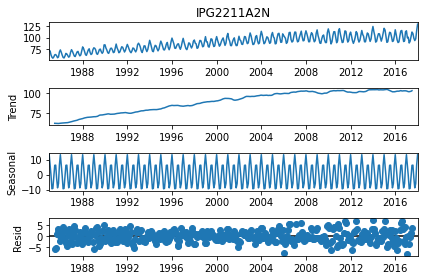

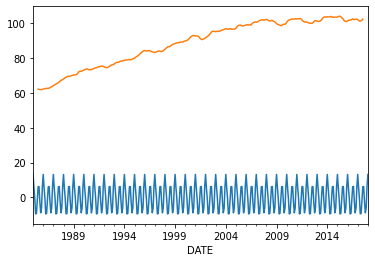

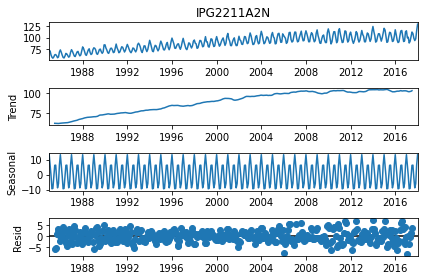

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['IPG2211A2N'], model = 'additive', period = 12)
result.seasonal.plot()
result.trend.plot()
result.plot()

In [57]:
def adf(col):
    adf = adfuller(df.loc[:, col].values, autolag = 'AIC')
    print("ADF Statistic:", adf[0])
    print("p-value:", adf[1])
    print("n_lags:", adf[2])
    for key, value in adf[4].items():
        print("Critical values:", key, value)
    if(adf[1]<0.05):
        print("Stationary data")
    else:
        print("Non-stationary data") 

In [58]:
adf('IPG2211A2N')

ADF Statistic: -2.2569903500472392
p-value: 0.18621469116586947
n_lags: 15
Critical values: 1% -3.4476305904172904
Critical values: 5% -2.869155980820355
Critical values: 10% -2.570827146203181
Non-stationary data


<AxesSubplot:xlabel='DATE'>

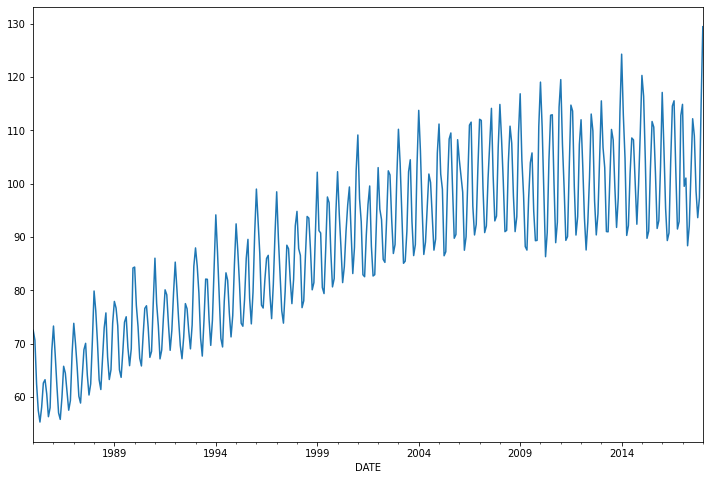

In [59]:
df['IPG2211A2N'].plot(figsize=(12,8))

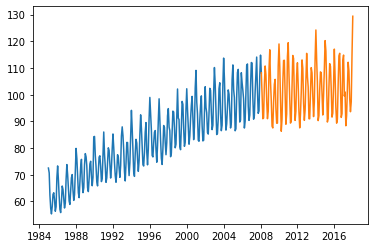

In [60]:
train = df[:278]
test = df[277:]
plt.plot(train)
plt.plot(test)

In [61]:
arima_model = pm.arima.auto_arima(train, d = 1, start_p=0, start_q = 0,
                                  max_p = 5, max_d=5, max_q=5, start_P=0,
                                  D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                                  m=12, season = True, trace = True,
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True, random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1323.162, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1271.842, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1198.309, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1295.909, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1200.307, Time=0.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1200.305, Time=0.74 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1250.924, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1200.998, Time=1.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1228.818, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1162.296, Time=0.55 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1164.236, Time=0.57 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1164.195, Time=1.43 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(1,1,2)[12]     

In [62]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  278
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -577.148
Date:                            Mon, 10 Apr 2023   AIC                           1162.296
Time:                                    14:53:38   BIC                           1176.615
Sample:                                01-01-1985   HQIC                          1168.049
                                     - 02-01-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4830      0.057      8.519      0.000       0.372       0.594
ma.L1         -0.9793      0.019    -51.804      0.000      -1.016      -0.942
ma.S.L12      -0.7205      0.054    -13.287      0.000      -0.827      -0.614
sigma2         4.3509      0.275     15.816      0.000       3.812       4.890
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                58.49
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
prediction = pd.DataFrame(arima_model.predict(n_periods=130), index = test.index)
prediction.columns = ['Predicted']
prediction.tail()

,Predicted
DATE,
2017-09-01,116.595635
2017-10-01,109.411507
2017-11-01,111.010554
2017-12-01,124.386637
2018-01-01,130.869415


In [64]:
model_sarima=sm.tsa.statespace.SARIMAX(df['IPG2211A2N'],order=(1, 1, 1),seasonal_order=(0,1,1,12))
model_sarima_fit=model_sarima.fit()

c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot:>

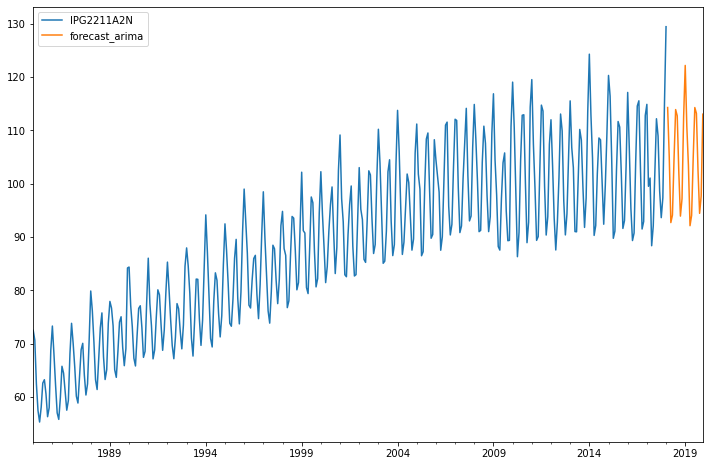

In [65]:
from pandas.tseries.offsets import DateOffset

future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df=pd.concat([df,future_datest_df])


future_df['forecast_arima'] = model_sarima_fit.predict(start = 397, end = 3000, dynamic= True)  
future_df[['IPG2211A2N', 'forecast_arima']].plot(figsize=(12, 8))

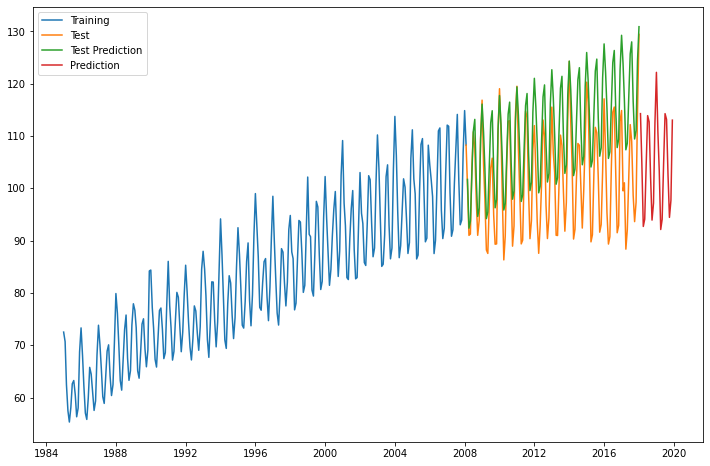

In [66]:
plt.figure(figsize = (12,8))
plt.plot(train, label = "Training")
plt.plot(test, label = "Test")
plt.plot(prediction, label = "Test Prediction")
plt.plot(future_df['forecast_arima'] , label = "Prediction")
plt.legend()
plt.show()

c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


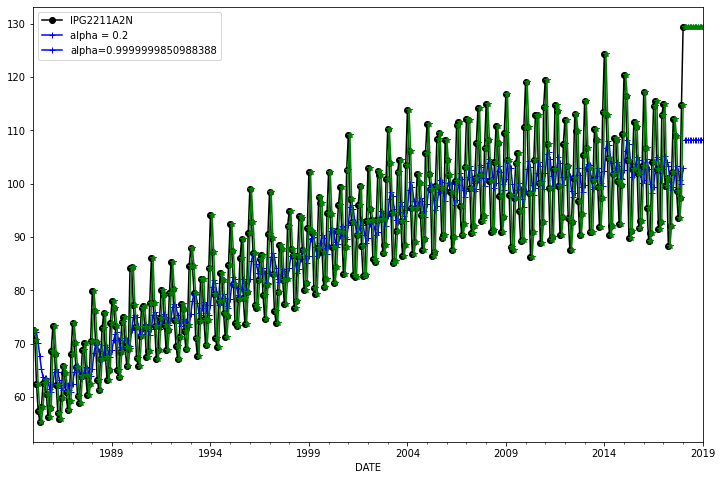

In [67]:
from statsmodels.tsa.api import SimpleExpSmoothing

n = 12
alpha = 0.2

model = SimpleExpSmoothing(df['IPG2211A2N']).fit(smoothing_level = alpha, optimized = False)
forecast1 = model.forecast(n).rename('alpha = ' + str(alpha))

model2 = SimpleExpSmoothing(df['IPG2211A2N']).fit()
forecast2 = model2.forecast(n).rename('alpha=%s'%model2.model.params['smoothing_level'])

ax = df.plot(marker = 'o', color = 'black', figsize=(12,8), legend=True)

forecast1.plot(marker='+', ax=ax, color='blue', legend=True)
model.fittedvalues.plot(marker='+', ax=ax, color='blue')

forecast2.plot(marker='*', ax=ax, color='green', legend=True)
model2.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.show()

c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


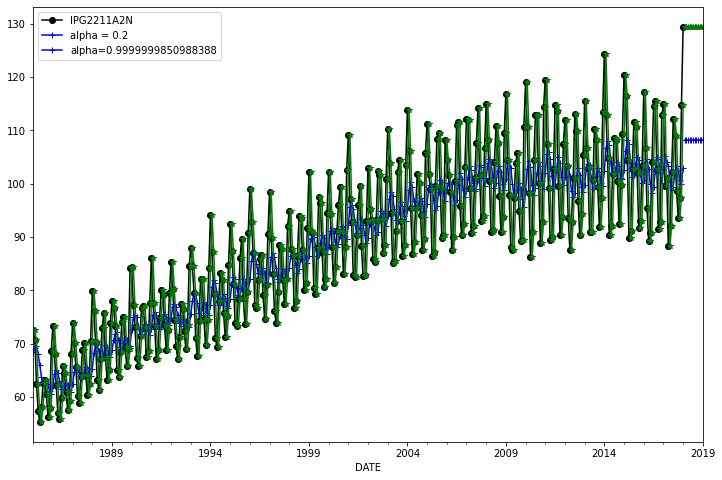

In [68]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

n = 12
alpha = 0.2

model = ExponentialSmoothing(df['IPG2211A2N']).fit(smoothing_level = alpha, optimized = False)
forecast1 = model.forecast(n).rename('alpha = ' + str(alpha))

model2 = ExponentialSmoothing(df['IPG2211A2N']).fit()
forecast2 = model2.forecast(n).rename('alpha=%s'%model2.model.params['smoothing_level'])

ax = df.plot(marker = 'o', color = 'black', figsize=(12,8), legend=True)

forecast1.plot(marker='+', ax=ax, color='blue', legend=True)
model.fittedvalues.plot(marker='+', ax=ax, color='blue')

forecast2.plot(marker='*', ax=ax, color='green', legend=True)
model2.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.show()

c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


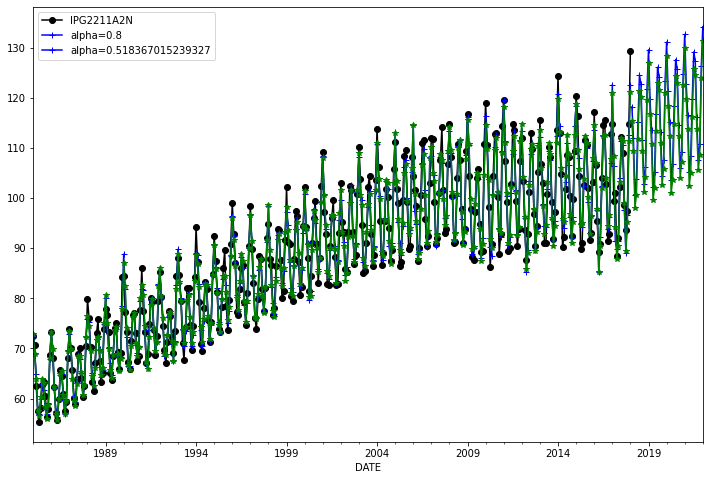

In [69]:
n = 48
alpha = 0.8
trend = 'add'
seasonal = 'mult'
sPeriod = 12

model1 = ExponentialSmoothing(df['IPG2211A2N'], trend, seasonal='add', seasonal_periods=sPeriod).fit(smoothing_level=alpha)
forecast1 = model1.forecast(n).rename('alpha='+str(alpha))

model3 = ExponentialSmoothing(df['IPG2211A2N'], trend, seasonal='add', seasonal_periods=sPeriod).fit()
forecast3 = model3.forecast(n).rename('alpha=%s'%model3.model.params['smoothing_level'])

ax = df.plot(marker='o', color='black', figsize=(12,8), legend=True)
forecast1.plot(marker='+', ax=ax, color='blue', legend=True)
model1.fittedvalues.plot(marker='+', ax=ax, color='blue')
forecast3.plot(marker='*', ax=ax, color='green', legend=True)
model3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.show()
